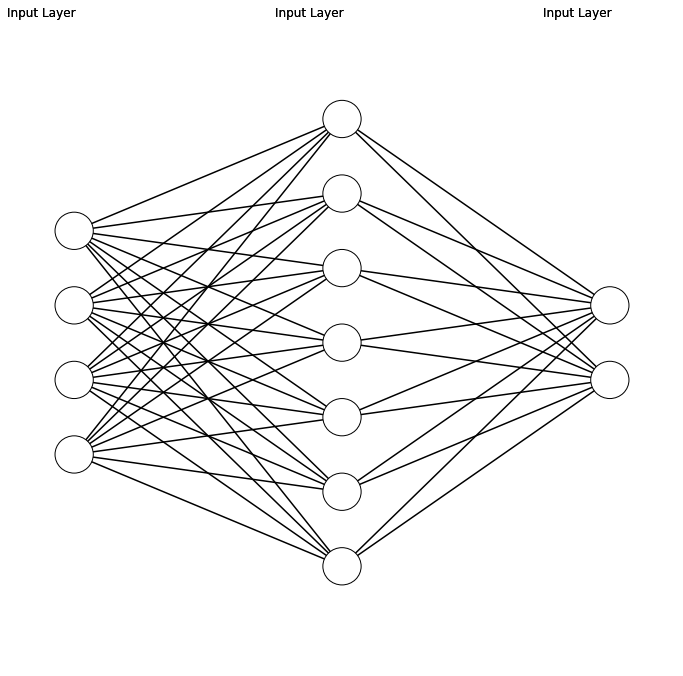

In [9]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            
            ax.add_artist(circle)
        text=plt.text(n*h_spacing+left , 1,'Input Layer', fontsize = 12)
        ax.add_artist(text)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()

ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [4, 7, 2])
fig.savefig('nn.png')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

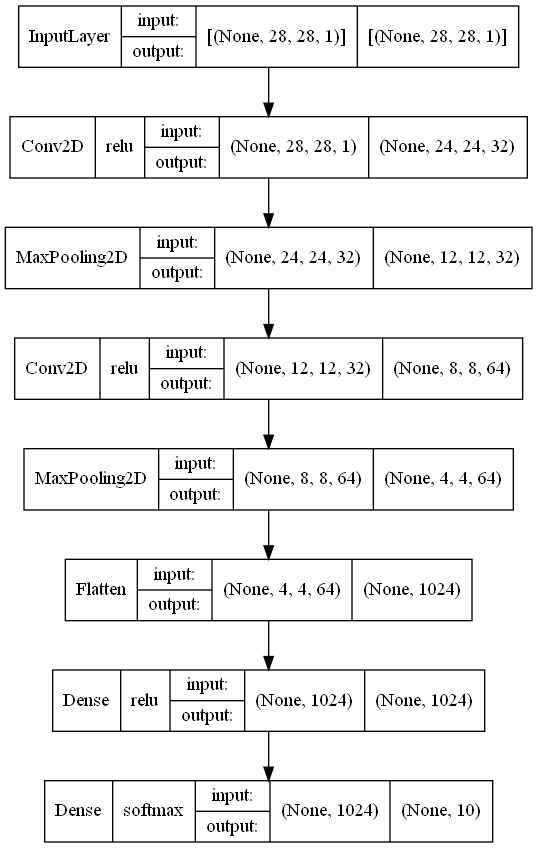

In [16]:

import tensorflow as tf

import numpy as np
from keras.datasets import mnist

from time import time 
import foolbox as fb
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.optimizers import adam_v2
from keras.losses import categorical_crossentropy
from tensorflow.keras.models import load_model
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
from timeit import default_timer as timer

model=load_model("models/vanilla_model")
model.summary()
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)


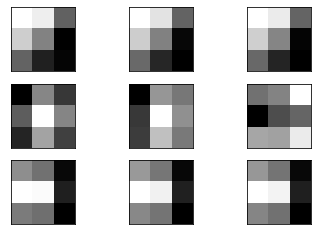

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


In [21]:
# cannot easily visualize filters lower down
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 3, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = pyplot.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		pyplot.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
pyplot.show()



# load the model
model = VGG16()
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

Epoch 1/20
235/235 [==============================] - 4s 13ms/step - loss: 0.7732 - accuracy: 0.8526 - val_loss: 0.0835 - val_accuracy: 0.9741
Epoch 2/20
235/235 [==============================] - 3s 11ms/step - loss: 0.1165 - accuracy: 0.9652 - val_loss: 0.0665 - val_accuracy: 0.9797
Epoch 3/20
235/235 [==============================] - 3s 12ms/step - loss: 0.0779 - accuracy: 0.9759 - val_loss: 0.0629 - val_accuracy: 0.9804
Epoch 4/20
235/235 [==============================] - 3s 11ms/step - loss: 0.0611 - accuracy: 0.9816 - val_loss: 0.0392 - val_accuracy: 0.9885
Epoch 5/20
235/235 [==============================] - 2s 10ms/step - loss: 0.0479 - accuracy: 0.9851 - val_loss: 0.0356 - val_accuracy: 0.9892
Epoch 6/20
235/235 [==============================] - 2s 10ms/step - loss: 0.0421 - accuracy: 0.9868 - val_loss: 0.0470 - val_accuracy: 0.9850
Epoch 7/20
235/235 [==============================] - 3s 11ms/step - loss: 0.0368 - accuracy: 0.9882 - val_loss: 0.0363 - val_accuracy: 0.9897

<ipython-input-15-bf56aecbd5f3>:88: RuntimeWarning: invalid value encountered in true_divide
  channel_image /= channel_image.std()


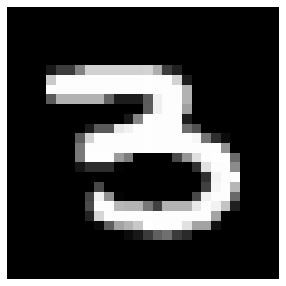

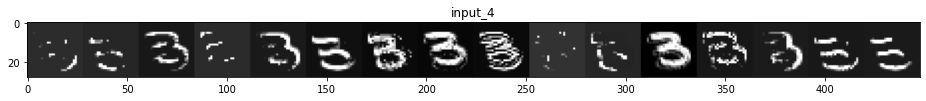

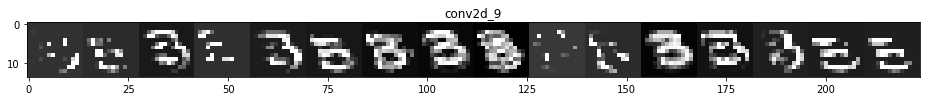

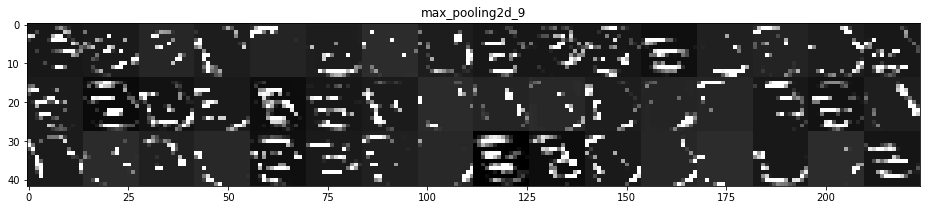

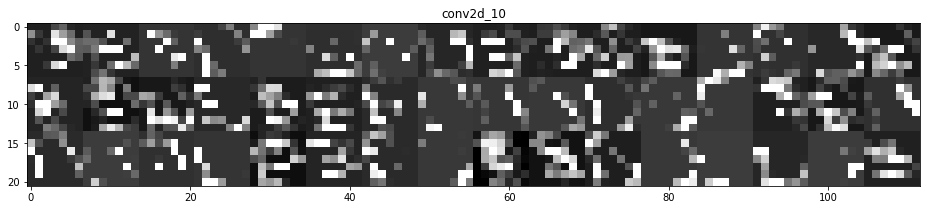

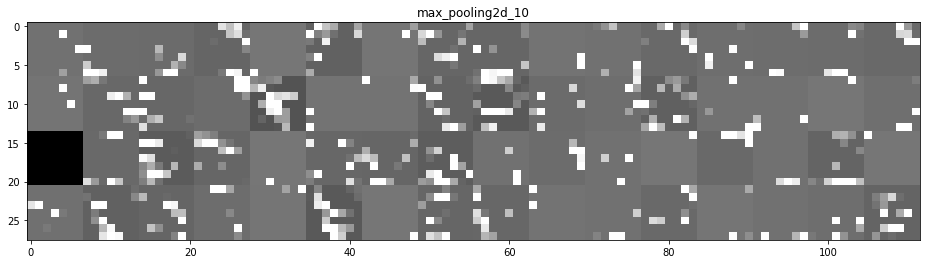

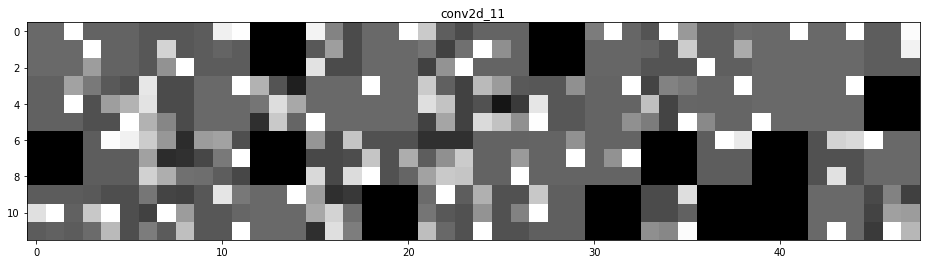

In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


    
inputs = Input(shape=(28,28,1))
x = Conv2D(24,kernel_size=(3,3),padding='same',activation="relu")(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(48, (3, 3), padding='same',activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), padding='same',activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(10,activation="softmax")(x)

model = Model(inputs,output)

model.compile(loss='categorical_crossentropy', 
            optimizer='adam', 
            metrics=['accuracy'])
    


(x_train, y_train), (x_test, y_test) = mnist.load_data()












epochs = 20
batch_size=256


history = model.fit(x_train,to_categorical(y_train),
         epochs=epochs,
         batch_size=batch_size,
         validation_data=(x_test,to_categorical(y_test)))





layer_outputs = [layer.output for layer in model.layers[1:7]]
# activation_model = Model(inputs=model.input,outputs=layer_outputs)


img = x_test[51].reshape(1,28,28,1)
fig = plt.figure(figsize=(5,5))
plt.imshow(img[0,:,:,0],cmap="gray")
plt.axis('off')

activation_model = Model(inputs=model.input,outputs=layer_outputs)
activations = activation_model.predict(img)

layer_names = []
for layer in model.layers[0:7]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='gray')